# Validation of method

### Table of contents

1. [**Schematic of models**](#schem)
2. [**Synthetic**](#syn)
3. [**Biophysical**](#bio)
4. [**Place cells regression**](#place)
5. [**Place cells comodulation**](#corr)

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr

import optax
jax.config.update('jax_platform_name', 'cpu')
#jax.config.update("jax_enable_x64", True)

import pickle


import sys

sys.path.append("../../../GaussNeuro")
import gaussneuro as lib

sys.path.append("../../scripts/fit")

import template



import matplotlib.pyplot as plt
plt.style.use(['paper.mplstyle'])
#plt.rc('text', usetex=True)

/var/home/dl543/Documents/Learning/nonparametric-modulated-renewal/scripts/plots/../../../GaussNeuro/gaussneuro/likelihoods/renewal.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
jax.config.update('jax_platform_name', 'cpu')
#jax.config.update('jax_disable_jit', True)

double_arrays = False

if double_arrays:
    jax.config.update("jax_enable_x64", True)
    array_type = "float64"
else:
    array_type = "float32"

# seed everything
seed = 123
prng_state = jr.PRNGKey(seed)
rng = np.random.default_rng(seed)

In [4]:
#import plot_logo

In [227]:
import plot_baselines

jitter = 1e-5
filters_dict = plot_baselines.spike_history_filters(rng, prng_state, jitter, array_type)

dt = 0.001
data_dict = plot_baselines.rate_rescaling(rng, dt, p = 0.003, ts = 3000)


time_t = data_dict['time']
rtime_t = data_dict['rescaled_time']
rates_t = data_dict['rates']
spike_times = data_dict["spike_times"]
rspike_times = data_dict["rescaled_spike_times"]

In [228]:
a, c = 6., 30.
phi_lower, phi_upper = a * np.log(c) - np.pi, (a * np.log(500 + c) + np.pi) * 0.87
print(phi_lower, phi_upper)

17.26559163638314 35.47760358279412


In [237]:
spike_times

array([ 424,  427, 1229, 1747, 1931, 2014, 2235, 2275])

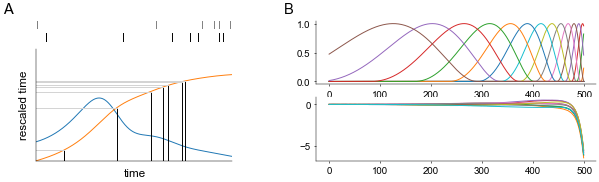

In [245]:
fig = plt.figure(figsize=(8, 2))
fig.text(-0.05, 1.05, 'A', fontsize=15, ha='center')
fig.text(0.45, 1.05, 'B', fontsize=15, ha='center')


### rate rescaling ###
widths = [1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.85, 
                        left=0.0, right=0.35, hspace=0.4)

ax = fig.add_subplot(spec[1, 0])
for st in spike_times:
    ax.plot(np.ones(2)*st, [0, 1], c='k')
ax.axis('off')
ax.set_ylim([0, 1])
ax.set_xlim([spike_times[0]-100, spike_times[-1]+100])

ax = fig.add_subplot(spec[0, 0])
for st in rspike_times:   
    ax.plot(np.ones(2)*st, [0, 1], c='gray')
ax.axis('off')
ax.set_ylim([0, 1])
ax.set_xlim([rspike_times[0]-100, rspike_times[-1]+100])


widths = [1]
heights = [1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=0.8, bottom=0.0, 
                        left=0.0, right=0.35, wspace=0.1)

ax = fig.add_subplot(spec[0, 0])

ax.plot(time_t, rates_t)
ax.plot(time_t, rtime_t)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('time')
ax.set_ylabel('rescaled time')

ax.set_xlim([time_t[0], time_t[-1]])
ax.set_ylim([rtime_t[0], 1.3*rtime_t[-1]])
for st, rst in zip(spike_times, rspike_times):
    ax.plot(np.ones(2)*st*dt, [0., rtime_t[st]], c='k')
    ax.plot([0., time_t[st]], np.ones(2)*rst*dt, c='lightgray')
    


### filters ###
widths = [1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.0, 
                        left=0.5, right=1., wspace=0.1)

ax = fig.add_subplot(spec[0, 0])

filter_t = filters_dict["glm_filter"]
t = np.arange(filter_t.shape[0])
ax.plot(t, filter_t[:, :, 0])


ax = fig.add_subplot(spec[1, 0])

filter_t = filters_dict["gp_filter"]
t = np.arange(filter_t.shape[1])

tr = 2
ax.plot(t, filter_t[:, :, 1, 0].T)



plt.savefig('../saves/baselines.pdf')
plt.show()

### Schematic of model

In [5]:
import plot_schematic

In [385]:
# seed everything
seed = 123
prng_state = jr.PRNGKey(seed)
rng = np.random.default_rng(seed)


evalsteps = 10000
L = 100.

evals, spiketimes, pos_sample, ISIs, tISI, tuISIs, tau, tau_tilde = plot_schematic.model_inputs(
    prng_state, rng, evalsteps, L)


num_samps = 10
evalsteps = 500
L = 3.0

cisi_t_eval, ISI_densities, cisi_tau_tilde, log_rho_tildes = plot_schematic.BNPP_samples(
    prng_state, rng, num_samps, evalsteps, L)

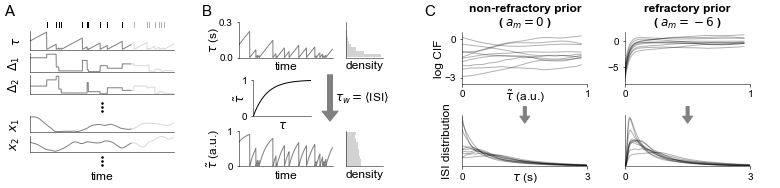

In [421]:
fig = plt.figure(figsize=(10, 2))
fig.text(-0.03, 1.05, 'A', fontsize=15, ha='center')
fig.text(0.245, 1.05, 'B', fontsize=15, ha='center')
fig.text(0.555, 1.05, 'C', fontsize=15, ha='center')

fig.text(1.03, 1.05, 'S', fontsize=15, alpha=0., ha='center')  # space


Tst = 500
T = 1200
Te = 1500


widths = [1]
heights = [0.3, 1, 1, 1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.5, 
                        left=0.0, right=0.2, wspace=0.1)


ax = fig.add_subplot(spec[0, 0])
spkts = spiketimes[(spiketimes > Tst) & (spiketimes < T)]
for st in spkts:
    ax.plot(evals[st]*np.ones(2), np.linspace(0, 1, 2), c='k')
    spkts = spiketimes[(T <= spiketimes) & (spiketimes < Te)]
for st in spkts:
    ax.plot(evals[st]*np.ones(2), np.linspace(0, 1, 2), c='k', alpha=0.3)
ax.set_xlim([evals[Tst], evals[Te]])
ax.set_ylim([0, 1])
ax.axis('off')


ax = fig.add_subplot(spec[1, 0])

ax.plot(evals[Tst:T], ISIs[Tst:T, 0, 0], c='gray')
ax.plot(evals[T:Te], ISIs[T:Te, 0, 0], c='gray', alpha=0.3)
ax.set_xlim([evals[Tst], evals[Te]])
ax.set_ylabel(r'$\tau$')
ax.set_yticks([])
ax.set_xticks([])


for k in range(2):
    ax = fig.add_subplot(spec[k + 2, 0])
    ax.plot(evals[Tst:T], ISIs[Tst:T, 0, k+1], c='gray')
    ax.plot(evals[T:Te], ISIs[T:Te, 0, k+1], c='gray', alpha=0.3)
    ax.set_xlim([evals[Tst], evals[Te]])
    ax.set_xticks([])
    ax.set_ylim(0)
    ax.set_yticks([])
    ax.set_ylabel('$\Delta_{}$'.format(k+1))

    
widths = [1]
heights = [1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=0.475, bottom=0.375, 
                        left=0.0, right=0.2, wspace=0.0)
ax = fig.add_subplot(spec[0, 0])
ax.scatter(np.zeros(3), np.arange(3), c='k', marker='.')
ax.set_ylim([-0.5, 3.5])
ax.axis('off')
    

widths = [1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=0.35, bottom=0.1, 
                        left=0.0, right=0.2, wspace=0.0)

for d in range(2):
    ax = fig.add_subplot(spec[d, 0])
    ax.plot(evals[Tst:T], pos_sample[0, Tst:T, d, 0], c='gray')
    ax.plot(evals[T:Te], pos_sample[0, T:Te, d, 0], alpha=0.3, c='gray')
    ax.set_xlim([evals[Tst], evals[Te]])
    ax.set_ylabel('$x_{}$'.format(d+1))
    ax.set_xticks([])
    ax.set_yticks([])
    
ax.set_xlabel('time', labelpad=20)


widths = [1]
heights = [1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=0.1, bottom=0.0, 
                        left=0.0, right=0.2, wspace=0.0)
ax = fig.add_subplot(spec[0, 0])
ax.scatter(np.zeros(3), np.arange(3), c='k', marker='.')
ax.set_ylim([-0.5, 3.5])
ax.axis('off')



### time warping ###
widths = [1, 0.4]
heights = [1, 1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.0, 
                        left=0.29, right=0.49, hspace=2.1)

ax = fig.add_subplot(spec[0, 0])
ax.plot(evals[Tst:Te], 1e-3 * ISIs[Tst:Te, 0, 0] * 1e3, c='gray')
ax.set_xticks([])
ax.set_xlim([evals[Tst], evals[Te]])
ax.set_xlabel('time', labelpad=4)
ax.set_ylabel(r'$\tau$ (s)', labelpad=-2)
ax.set_ylim([0, .3])
ax.set_yticks([0, .3])

ax = fig.add_subplot(spec[0, 1])
ax.hist(ISIs[:, 0, 0], orientation='horizontal', color='lightgray', density=True)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(0)
ax.set_xlabel('density', labelpad=3)


ax = fig.add_subplot(spec[1, 0])
ax.plot(evals[Tst:Te], tISI[Tst:Te, 0], c='gray')
ax.set_xticks([])
ax.set_xlim([evals[Tst], evals[Te]])
ax.set_xlabel('time', labelpad=4)
ax.set_ylabel(r'$\tilde{\tau}$ (a.u.)', labelpad=5)
ax.set_ylim([0, 1])
ax.set_yticks([0, 1])

ax = fig.add_subplot(spec[1, 1])
ax.hist(tISI[:, 0], orientation='horizontal', color='lightgray', density=True)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim([0, 1])
ax.set_xlim([0, 3])
ax.set_xlabel('density', labelpad=3)


widths = [1]
heights = [1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=0.6, bottom=0.35, 
                        left=0.31, right=0.39)

ax = fig.add_subplot(spec[0, 0])
ax.plot(tau[:, 0], tau_tilde[:, 0], c='k')
ax.set_xticks([])
ax.set_yticks([0, 1])
ax.set_xlim([tau[0, 0], tau[-1, 0]])
ax.set_ylim([0, 1])
ax.set_xlabel(r'$\tau$', labelpad=4)
ax.set_ylabel(r'$\tilde{\tau}$', labelpad=-5)

ax.text(0.57, 0.5, r"$\tau_w = \langle$" + "ISI" + r"$\rangle$", fontsize=12, va='center')
ax.annotate("", xy=(1.33, -0.2), xytext=(1.33, 1.2), rotation=np.pi/2., xycoords='axes fraction', 
    arrowprops=dict(arrowstyle="simple, head_width=1.6, head_length=1.0, tail_width=0.5", color='gray'), 
    annotation_clip=False)


### log intensity and ISI ###
n = 0
f_dim = 0

widths = [1, 1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=0.93, bottom=0.0, 
                        left=0.6, right=1.0, hspace=0.6, wspace=0.3)

ax = fig.add_subplot(spec[0, 0])
ax.set_title(r"non-refractory prior" + "\n" + r"( $a_m = 0$ )", fontsize=12, fontweight='bold')
ax.plot(cisi_tau_tilde, log_rho_tildes[0][:, f_dim, :].T, c='k', alpha=0.3)
ax.set_ylim([-3.5, 0.5])
ax.set_yticks([-3, 0])
ax.set_ylabel('log CIF', labelpad=1)
ax.set_xlabel(r'$\tilde{\tau}$ (a.u.)', labelpad=-11)
ax.set_xlim([0, 1])
ax.set_xticks([0, 1])

ax = fig.add_subplot(spec[0, 1])
ax.set_title(r"refractory prior" + "\n" + r"( $a_m = -6$ )", fontsize=12, fontweight='bold')
ax.plot(cisi_tau_tilde, log_rho_tildes[1][:, f_dim, :].T, c='k', alpha=0.3)
ax.set_xticks([0, 1])
ax.set_xlim([0, 1])

ax = fig.add_subplot(spec[1, 0])
ax.plot(cisi_t_eval, ISI_densities[0][:, f_dim, :].T, c='k', alpha=0.3)
ax.set_xticks([0, 3])
ax.set_yticks([])
ax.set_ylabel('ISI distribution', labelpad=10)
ax.set_xlabel(r'$\tau$ (s)', labelpad=-11)
ax.set_xlim([cisi_t_eval[0], cisi_t_eval[-1]])
ax.set_ylim(0)

ax.annotate("", xy=(0.5, 0.8), xytext=(0.5, 1.2), rotation=np.pi/2., xycoords='axes fraction', 
    arrowprops=dict(arrowstyle="simple, head_width=1.0, head_length=0.7, tail_width=0.3", color='gray'), 
    annotation_clip=False)


ax = fig.add_subplot(spec[1, 1])
ax.plot(cisi_t_eval, ISI_densities[1][:, f_dim, :].T, c='k', alpha=0.3)
ax.set_xticks([0, 3])
ax.set_yticks([])
ax.set_xlim([cisi_t_eval[0], cisi_t_eval[-1]])
ax.set_ylim(0)

ax.annotate("", xy=(0.5, 0.8), xytext=(0.5, 1.2), rotation=np.pi/2., xycoords='axes fraction', 
    arrowprops=dict(arrowstyle="simple, head_width=1.0, head_length=0.7, tail_width=0.3", color='gray'), 
    annotation_clip=False)



plt.savefig('../saves/schematic.pdf')
plt.show()

In [543]:
datadir = '../saves/'
name = 'results_synthetic'

results = pickle.load(
    open(datadir + name + ".p", "rb")
)

In [544]:
results["tuning"].keys()

dict_keys(['pos_x_locs', 'pos_isi_locs', 'pos_mean_ISI', 'pos_mean_invISI', 'pos_CV_ISI', 'GT_rates', 'ISI_t_eval', 'unit_ISI_t_eval', 'ISI_deltas_conds', 'ISI_xs_conds', 'ISI_neuron_conds', 'ISI_densities', 'GT_ISI_densities', 'GT_unit_renewals', 'warp_tau', 'len_tau', 'len_deltas', 'len_xs'])

In [545]:
regression_dict = results["regression"]
reg_config_names = list(regression_dict.keys())

In [546]:
tuning_dict = results["tuning"]

pos_x_locs = tuning_dict["pos_x_locs"]
GT_rates = tuning_dict["GT_rates"]
pos_mean_ISI = tuning_dict["pos_mean_ISI"]
pos_est_rate = 1 / pos_mean_ISI.mean(0)

ISI_t_eval = tuning_dict["ISI_t_eval"]
unit_ISI_t_eval = tuning_dict["unit_ISI_t_eval"]

ISI_densities = tuning_dict["ISI_densities"]
ISI_neuron_conds = tuning_dict["ISI_neuron_conds"]
GT_unit_renewals = tuning_dict["GT_unit_renewals"]
GT_ISI_densities = tuning_dict["GT_ISI_densities"]


warp_tau = tuning_dict['warp_tau']
len_tau = tuning_dict['len_tau']
len_deltas = tuning_dict['len_deltas']

ARD_order = []
for n in range(len_deltas.shape[0]):
    ARD_order.append(np.sum(len_deltas[n] < 3.) + 1)

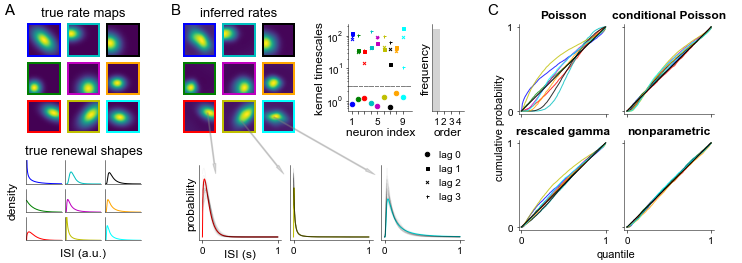

In [563]:
fig = plt.figure(figsize=(8, 3))


fig.text(-0.03, 1.05, 'A', fontsize=15, ha='center')
fig.text(0.26, 1.05, 'B', fontsize=15, ha='center')
fig.text(0.81, 1.05, 'C', fontsize=15, ha='center')

fig.text(1.23, 1.05, 'S', fontsize=15, alpha=0., ha='center')  # space


# cell ID colour
cs = [
    'b',
    'g',
    'r',
    'c',
    'm',
    'y',
    'k',
    'orange',
    'cyan'
]



### ground truth ###
fig.text(0.1, 1.04, 'true rate maps', fontsize=13, ha='center')

widths = [1] * 3
heights = [1] * 3
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.5, 
                        left=0.0, right=0.2, wspace=0.1)

for n in range(3):
    for m in range(3):
        k = 3*n + m
        ax = fig.add_subplot(spec[m, n])

        ax.imshow(GT_rates[..., k], vmin=0., 
                  origin='lower', cmap='viridis')
        lib.utils.plots.decorate_ax(ax)
        for spine in ax.spines.values():
            spine.set_edgecolor(cs[k])
            spine.set_linewidth(2)


widths = [1] * 3
heights = [1] * 3
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=0.37, bottom=0.0, 
                        left=0.0, right=0.2, wspace=0.1)

for n in range(3):
    for m in range(3):
        k = 3*n + m
        
        ax = fig.add_subplot(spec[m, n])
        ax.plot(unit_ISI_t_eval, GT_unit_renewals[:, k], c=cs[k])
        ax.set_xlim([-0.1, unit_ISI_t_eval[-1]])
        ax.set_ylim([0, 2.])
        ax.set_xticks([])
        ax.set_yticks([])
        
        if m == 0 and n == 1:
            ax.set_title('true renewal shapes', fontsize=13)
            
        if m == 1 and n == 0:
            ax.set_ylabel('density')
            
        if m == 2 and n == 1:
            ax.set_xlabel('ISI (a.u.)')
    


### tuning curves ###
fig.text(0.37, 1.04, 'inferred rates', fontsize=13, ha='center')

widths = [1] * 3
heights = [1] * 3
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.5, 
                        left=0.27, right=0.47, wspace=0.1)

for n in range(3):
    for m in range(3):
        k = 3*n + m
        ax = fig.add_subplot(spec[m, n])

        ax.imshow(pos_est_rate[k], vmin=0., 
                  origin='lower', cmap='viridis')
        lib.utils.plots.decorate_ax(ax)
        for spine in ax.spines.values():
            spine.set_edgecolor(cs[k])
            spine.set_linewidth(2)
    

### conditional ISI distributions ###
widths = [1] * 3
heights = [1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=0.35, bottom=0.0, 
                        left=0.3, right=0.76, wspace=0.1)


for en, ne in enumerate(ISI_neuron_conds):
    ax = fig.add_subplot(spec[0, en])
    dens = ISI_densities[:, en, :]
    gt_dens = GT_ISI_densities[en, :, ne]
    ax.plot(ISI_t_eval, gt_dens, c=cs[ne], alpha=1.0, 
            label='truth' if en == 1 else None)
    ax.plot(ISI_t_eval, dens.T, c='k', alpha=0.03, 
            label='posterior samples' if en == 1 else None)
    
    ax.set_yticks([])
    if en == 0:
        ax.set_ylabel('probability', labelpad=2)
        ax.set_xlabel('ISI (s)', labelpad=-6)
    #if en == 1:
    #    ax.legend(loc='right', bbox_to_anchor=(0.8, 0.8))
        

widths = [1]
heights = [1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.0, 
                        left=0.3, right=0.6, wspace=0.1)

ax = fig.add_subplot(spec[0, 0])

ax.annotate("", xy=(0.1, 0.3), xytext=(0.05, 0.6), rotation=np.pi/2., xycoords='axes fraction', 
    arrowprops=dict(arrowstyle="simple, head_width=0.3, head_length=1.0, tail_width=0.1", 
                    color='gray', alpha=0.3), 
    annotation_clip=False)

ax.annotate("", xy=(0.5, 0.3), xytext=(0.24, 0.56), rotation=np.pi/2., xycoords='axes fraction', 
    arrowprops=dict(arrowstyle="simple, head_width=0.3, head_length=1.0, tail_width=0.1", 
                    color='gray', alpha=0.3), 
    annotation_clip=False)

ax.annotate("", xy=(1.03, 0.3), xytext=(0.425, 0.575), rotation=np.pi/2., xycoords='axes fraction', 
    arrowprops=dict(arrowstyle="simple, head_width=0.3, head_length=1.0, tail_width=0.1", 
                    color='gray', alpha=0.3), 
    annotation_clip=False)

ax.axis('off')


### kernel lengthscales ###
widths = [1, 0.5]
heights = [1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.6, 
                        left=0.56, right=0.76, wspace=0.4)

markers = ['o', 's', 'x', '+']

ax = fig.add_subplot(spec[0, 0])
for n in range(9):
    lens = len_deltas[n]
    tlen = len_tau[n]
    ax.scatter(n, tlen, marker=markers[0], c=cs[n], s=20, 
               label='lag 0' if n == 0 else None)
    for k in range(1, 4):
        ax.scatter(n, lens[k-1], marker=markers[k], c=cs[n], 
                   label='lag {}'.format(k) if n == 0 else None)
        
    ax.set_yscale('log')
    ax.set_ylabel('kernel timescales', labelpad=1)
    ax.plot([-.5, 9.5], 3. * np.ones(2), '--', color='gray')
    ax.set_xlim([-.5, 9.5])
    ax.set_xlabel('neuron index', labelpad=1)
    ax.set_xticks(list(range(9)))
    ax.set_xticklabels([1, '', '', '', 5, '', '', '', 9])
    leg = ax.legend(loc='right', bbox_to_anchor=(1.9, -0.75), handletextpad=0.2)
    for k in range(4):
        leg.legend_handles[k].set_color('k')
    
ax = fig.add_subplot(spec[0, 1])
ax.hist(ARD_order, bins=np.linspace(0, 4, 5) + .5, color='lightgray')
ax.set_yticks([])
ax.set_xticks([1, 2, 3, 4])
ax.set_ylabel('frequency', labelpad=1)
ax.set_xlabel('order', labelpad=1)


### KS statistics ###
widths = [1, 1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.05, 
                        left=0.85, right=1.2, hspace=0.3, wspace=0.1)

use_reg_config_names = [reg_config_names[k] for k in [0, 1, 2, 4]]
use_names = [
    'Poisson', 
    'conditional Poisson', 
    'rescaled gamma', 
    'nonparametric', 
]
for en, n in enumerate(use_reg_config_names):
    ax = fig.add_subplot(spec[en // 2, en % 2])
    ax.set_title(use_names[en], fontsize=12, fontweight='bold')
    
    dd = regression_dict[n]
    sort_cdfs = dd['KS_quantiles']

    for n in range(len(sort_cdfs)):
        if sort_cdfs[n] is not None:
            ax.plot(sort_cdfs[n], np.linspace(0., 1., len(sort_cdfs[n])), c=cs[n], alpha=0.8)
    ax.plot(np.linspace(0., 1., 100), np.linspace(0., 1., 100), c='k')
    ax.set_xlim([-0.03, 1.03])
    ax.set_xticks([0, 1])
    if en // 2 == 0:
        ax.set_xticklabels([])
    ax.set_ylim([-0.03, 1.03])
    ax.set_yticks([0, 1])
    if en % 2 == 1:
        ax.set_yticklabels([])
    ax.set_aspect(1.0)

fig.text(1.025, -0.075, 'quantile', ha='center', fontsize=11)
fig.text(0.815, 0.525, 'cumulative probability', rotation=90, va='center', fontsize=11)
    
    
        
plt.savefig('../saves/synthetic.pdf')
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 3))


### baseline rate maps ###


### ARD failure ###

## th1

In [329]:
datadir = '../saves/'
name = 'results_th1'

results = pickle.load(
    open(datadir + name + ".p", "rb")
)

In [330]:
regression_dict = results["regression"]
tuning_dict = results["tuning"]
variability_dict = results["variability"]

reg_config_names = list(regression_dict.keys())


In [308]:
median.shape

(33, 100)

In [213]:
tuning_dict.keys()

dict_keys(['neuron_list', 'hd_x_locs', 'hd_isi_locs', 'hd_mean_ISI', 'hd_mean_invISI', 'hd_CV_ISI', 'ISI_t_eval', 'ISI_deltas_conds', 'ISI_xs_conds', 'ISI_densities', 'warp_tau', 'len_tau', 'len_deltas', 'len_xs'])

In [290]:
eval_locs = tuning_dict["hd_x_locs"]

In [371]:
rEsamples = 1 / tuning_dict["hd_mean_ISI"]
percentiles = lib.utils.stats.percentiles_from_samples(
    rEsamples, percentiles=[0.05, 0.5, 0.95])

sm_filter = np.ones(5) / 5
padding_modes = ['periodic']
rElower, rEmedian, rEupper = [
    lib.utils.stats.smooth_histogram(p, sm_filter, padding_modes) for p in percentiles
]

Ersamples = tuning_dict["hd_mean_invISI"]
percentiles = lib.utils.stats.percentiles_from_samples(
    Ersamples, percentiles=[0.05, 0.5, 0.95])

sm_filter = np.ones(5) / 5
padding_modes = ['periodic']
Erlower, Ermedian, Erupper = [
    lib.utils.stats.smooth_histogram(p, sm_filter, padding_modes) for p in percentiles
]


cvsamples = tuning_dict["hd_CV_ISI"]
percentiles = lib.utils.stats.percentiles_from_samples(
    cvsamples, percentiles=[0.05, 0.5, 0.95])

sm_filter = np.ones(5) / 5
padding_modes = ['periodic']
cvlower, cvmedian, cvupper = [
    lib.utils.stats.smooth_histogram(p, sm_filter, padding_modes) for p in percentiles
]

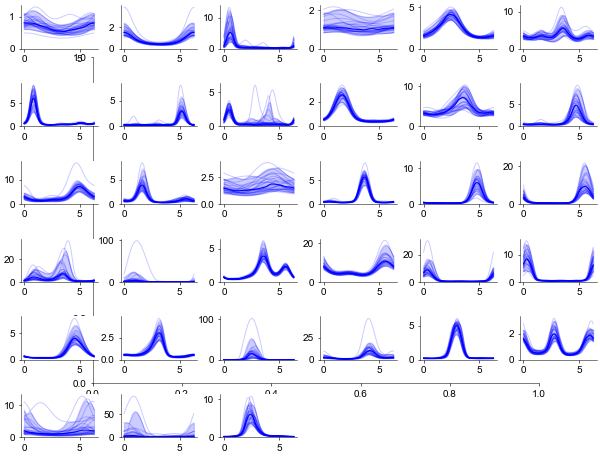

In [370]:
fig, ax = plt.subplots(figsize=(8, 6))
fig.set_facecolor('white')

W, H = 6, 6
widths = [1] * W
heights = [1] * H

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.0, 
                        left=0.0, right=1.0, wspace=0.3, hspace=0.8)

for n in range(W):
    for m in range(H):
        ne = m + n*W
        if ne >= rmedian.shape[0]:
            continue

        ax = fig.add_subplot(spec[n, m])
        line, = ax.plot(eval_locs[:, 0], rmedian[ne, :], 'b', label='posterior mean')
        ax.fill_between(eval_locs[:, 0], rlower[ne, :], rupper[ne, :], 
                        color=line.get_color(), alpha=0.2, label='95% confidence')
        ax.plot(eval_locs[:, 0], rsamples[:, ne, :].T, 'b', alpha=0.2)
        ax.set_ylim(0)

plt.savefig('invEtau.png', dpi=60)
plt.show()

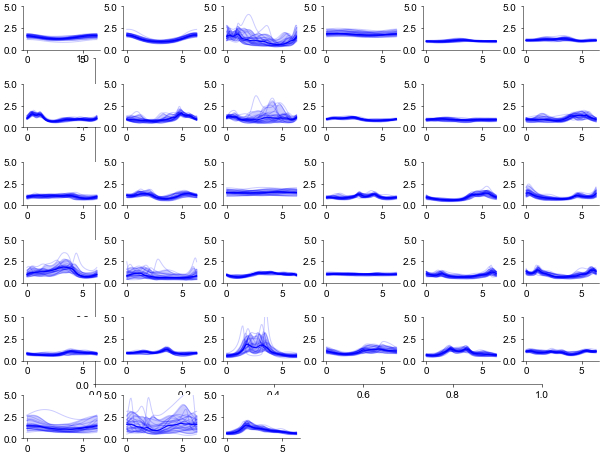

In [357]:
fig, ax = plt.subplots(figsize=(8, 6))


W, H = 6, 6
widths = [1] * W
heights = [1] * H

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.0, 
                        left=0.0, right=1.0, wspace=0.3, hspace=0.8)

for n in range(W):
    for m in range(H):
        ne = m + n*W
        if ne >= cvmedian.shape[0]:
            continue

        ax = fig.add_subplot(spec[n, m])
        line, = ax.plot(eval_locs[:, 0], cvmedian[ne, :], 'b', label='posterior mean')
        ax.fill_between(eval_locs[:, 0], cvlower[ne, :], cvupper[ne, :], 
                        color=line.get_color(), alpha=0.2, label='95% confidence')
        ax.plot(eval_locs[:, 0], cvsamples[:, ne, :].T, 'b', alpha=0.2)
        ax.set_ylim([0, 5])

plt.show()

In [377]:
imISI = 1 / variability_dict["mean_ISI"].mean(0)
#imISI = variability_dict["mean_invISI"].mean(0)
cvISI = variability_dict["CV_ISI"].mean(0)

In [381]:
variability_dict["linear_R2"]

array([0.0150001 , 0.01251537, 0.01191831, ..., 0.190512  , 0.11402702,
       0.04410118], dtype=float32)

In [382]:
variability_dict.keys()

dict_keys(['mean_ISI', 'CV_ISI', 'linear_slope', 'linear_intercept', 'linear_R2', 'GP_tracker', 'GP_post_locs', 'GP_post_mean', 'GP_R2'])

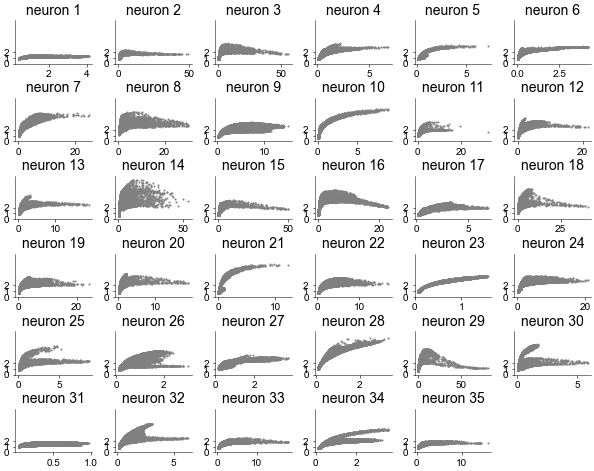

In [363]:
fig = plt.figure(figsize=(8, 6))

#fig.text(0.22, 1.05, 'repeatable trials', fontsize=12, ha='center')
#fig.text(0.78, 1.05, 'naturalistic behaviour', fontsize=12, ha='center')


### moment-by-moment ###
W, H = 6, 6
widths = [1] * W
heights = [1] * H

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.0, 
                        left=0.0, right=1.0, wspace=0.3, hspace=0.8)

for n in range(W):
    for m in range(H):
        ne = m + n*W
        if ne >= imISI.shape[0]:
            continue
            
        ax = fig.add_subplot(spec[n, m])
        ax.set_title('neuron {}'.format(ne + 1))
        ax.scatter(imISI[ne], cvISI[ne], marker='.', c='gray', s=4)
        ax.set_ylim([0, cvISI.max() * 1.1])
        ax.set_yticks([0, 1, 2])
        
plt.show()

In [410]:
warp_tau = tuning_dict['warp_tau']
len_tau = tuning_dict['len_tau']
len_deltas = tuning_dict['len_deltas']

ARD_order = []
for n in range(len_deltas.shape[0]):
    ARD_order.append(np.sum(len_deltas[n] < 3.) + 1)

In [359]:
plot_units = [20, 27]

In [263]:
len(regression_dict[reg_config_names[-1]]['pred_ts'])

10000

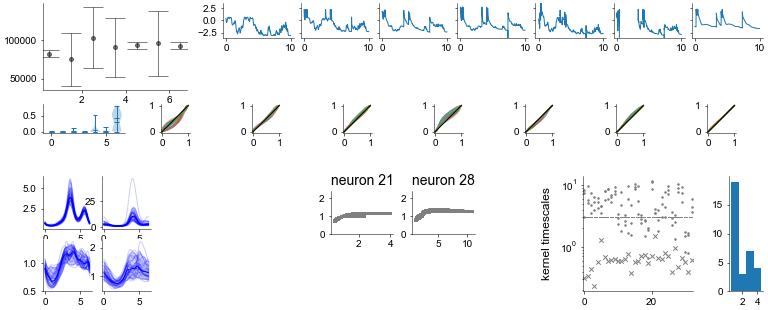

In [417]:
fig = plt.figure(figsize=(10, 4))

#fig.text(0.22, 1.05, 'repeatable trials', fontsize=12, ha='center')
#fig.text(0.78, 1.05, 'naturalistic behaviour', fontsize=12, ha='center')


### likelihoods ###
widths = [1]
heights = [1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.7, 
                        left=0.0, right=0.2, wspace=0.1)

use_reg_config_names = [reg_config_names[k] for k in [0, 1, 2, 3, 4, 5, 9]]

mdls = len(use_reg_config_names)
test_lls = np.array([regression_dict[n]['test_ells'] for n in use_reg_config_names])
train_lls = np.array([regression_dict[n]['train_ell'] for n in use_reg_config_names])

ax = fig.add_subplot(spec[0, 0])
means = test_lls.mean(-1)
sems = test_lls.std(-1) / np.sqrt(test_lls.shape[-1])
ax.errorbar(
    .5 + np.arange(mdls), means, yerr=sems, 
    alpha=0.5, color='black', capsize=10, linestyle='', 
    marker='o', markersize=4,
)

#folds = test_lls.shape[-1]
#eps = 0.1
#for m in range(mdls):
#    ax.scatter(.5 + m + eps * rng.normal(size=(folds,)), test_lls[m], c='k', marker='.')
#ax.bar(np.arange(mdls), means, yerr=sems, 
#       align='center', alpha=0.5, ecolor='black', capsize=10)
#ax.set_ylim(7.5 * 1e4)

# ax = fig.add_subplot(spec[1, 0])
# means = train_lls
# ax.bar(np.arange(mdls), means, 
#        align='center', alpha=0.5, ecolor='black', capsize=10)



widths = [1] * (len(use_reg_config_names))
heights = [1, 0.1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.85, 
                        left=0.25, right=1., hspace=0.3, wspace=0.1)

test_fold = 0
ne = 0
for en, n in enumerate(use_reg_config_names):
    pred_lint = regression_dict[n]['pred_log_intensities']
    pred_ts = regression_dict[n]['pred_ts']
    ax = fig.add_subplot(spec[0, en])
    ax.plot(pred_ts, pred_lint[test_fold][0, ne, :])
    ax.set_ylim([-3.5, 3.5])
    if en > 0:
        ax.set_yticklabels([])
#     sts = regression_dict[n]['pred_spiketimes'][test_fold][ne]
#     ax = fig.add_subplot(spec[1, en])
#     for st in sts:
#         ax.plot(st*np.ones(2), np.linspace(0, 1, 2))


### KS statistics ###
widths = [1] * (len(use_reg_config_names) + 1)
heights = [1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=0.65, bottom=0.55, 
                        left=0.0, right=1., wspace=0.1)

ax = fig.add_subplot(spec[0, 0])

mdls = len(use_reg_config_names)
p_vals = [regression_dict[n]['KS_p_value'] for n in use_reg_config_names]

ax.violinplot(
    p_vals, list(range(mdls)), points=20, widths=0.9,
    showmeans=True, showextrema=True, showmedians=True, 
    bw_method='silverman', 
)

for en, n in enumerate(use_reg_config_names):
    quantiles = regression_dict[n]['KS_quantiles']

    ax = fig.add_subplot(spec[0, en + 1])
    for n in range(len(quantiles)):
        if quantiles[n] is not None:
            ax.plot(np.linspace(0., 1., len(quantiles[n])), quantiles[n], alpha=0.7)
    ax.plot(np.linspace(0., 1., 100), np.linspace(0., 1., 100), c='k')
    ax.set_aspect(1.)


    
### tuning ###
widths = [1, 1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=0.4, bottom=0.0, 
                        left=0.0, right=0.15)

for en, n in enumerate(plot_units):
    ax = fig.add_subplot(spec[0, en])
    line, = ax.plot(eval_locs[:, 0], rmedian[n, :], 'b', label='posterior mean')
    ax.fill_between(eval_locs[:, 0], rlower[n, :], rupper[n, :], 
                    color=line.get_color(), alpha=0.2, label='95% confidence')
    ax.plot(eval_locs[:, 0], rsamples[:, n, :].T, 'b', alpha=0.2)
    
    ax = fig.add_subplot(spec[1, en])
    line, = ax.plot(eval_locs[:, 0], cvmedian[n, :], 'b', label='posterior mean')
    ax.fill_between(eval_locs[:, 0], cvlower[n, :], cvupper[n, :], 
                    color=line.get_color(), alpha=0.2, label='95% confidence')
    ax.plot(eval_locs[:, 0], cvsamples[:, n, :].T, 'b', alpha=0.2)

    
    

### moment-by-moment ###
widths = [1, 1]
heights = [1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=0.35, bottom=0.2, 
                        left=0.4, right=0.6, wspace=0.3, hspace=0.8)

for en, ne in enumerate(plot_units):
    ax = fig.add_subplot(spec[0, en])
    ax.set_title('neuron {}'.format(ne + 1))
    ax.scatter(imISI[ne], cvISI[ne], marker='.', c='gray', s=4)
    ax.set_ylim([0, cvISI.max() * 1.1])
    ax.set_yticks([0, 1, 2])
    
    
widths = [1, 1]
heights = [1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=0.15, bottom=0.0, 
                        left=0.4, right=0.6, wspace=0.3, hspace=0.8)
    
    
    
### kernel lengthscales ###
widths = [1, 0.3]
heights = [1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=0.4, bottom=0.0, 
                        left=0.75, right=1.0, wspace=0.5)

ax = fig.add_subplot(spec[0, 0])
for n in range(len_deltas.shape[0]):
    lens = len_deltas[n]
    tlen = len_tau[n]
    ax.scatter(n*np.ones_like(lens), lens, marker='.', c='gray')
    ax.scatter(n*np.ones(1), tlen, marker='x', c='gray', s=20)
    ax.set_yscale('log')
    ax.set_ylabel('kernel timescales')
    ax.plot([-.5, len_deltas.shape[0] - 0.5], 3. * np.ones(2), '--', color='gray')
    ax.set_xlim([-.5, len_deltas.shape[0] - 0.5])
    
ax = fig.add_subplot(spec[0, 1])
ax.hist(ARD_order, bins=np.linspace(0, 4, 5) + .5)



plt.show()

<ErrorbarContainer object of 3 artists>

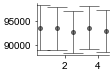

In [280]:
fig = plt.figure(figsize=(10, 4))

#fig.text(0.22, 1.05, 'repeatable trials', fontsize=12, ha='center')
#fig.text(0.78, 1.05, 'naturalistic behaviour', fontsize=12, ha='center')


### compare different BNPPs th1 ###
widths = [1]
heights = [1, 1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.6, 
                        left=0.0, right=0.1, wspace=0.1)


use_reg_config_names = [reg_config_names[k] for k in [4, 6, 7, 8, 9]]

mdls = len(use_reg_config_names)
test_lls = np.array([regression_dict[n]['test_ells'] for n in use_reg_config_names])
train_lls = np.array([regression_dict[n]['train_ell'] for n in use_reg_config_names])

ax = fig.add_subplot(spec[0, 0])
means = test_lls.mean(-1)
sems = test_lls.std(-1) / np.sqrt(test_lls.shape[-1])
ax.errorbar(
    .5 + np.arange(mdls), means, yerr=sems, 
    alpha=0.5, color='black', capsize=10, linestyle='', 
    marker='o', markersize=4,
)



### compare different BNPPs hc3 ###

## hc3

In [268]:
datadir = '../saves/'
name = 'results_hc3'

results = pickle.load(
    open(datadir + name + ".p", "rb")
)

In [269]:

regression_dict = results["regression"]
tuning_dict = results["tuning"]
variability_dict = results["variability"]

reg_config_names = list(regression_dict.keys())


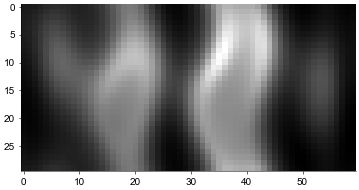

In [270]:
plt.imshow(tuning_dict["xt_CV_ISI"][:, 1, ...].mean(0), cmap='gray')

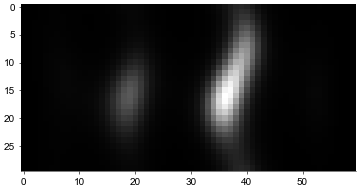

In [271]:
plt.imshow(1/tuning_dict["xt_mean_ISI"][:, 1, ...].mean(0), cmap='gray')

In [272]:
imISI = 1 / variability_dict["mean_ISI"].mean(0)
#imISI = variability_dict["mean_invISI"].mean(0)
cvISI = variability_dict["CV_ISI"].mean(0)

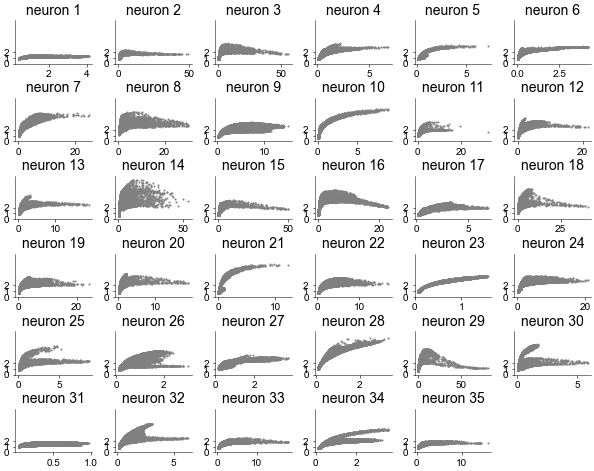

In [273]:
fig = plt.figure(figsize=(8, 6))

#fig.text(0.22, 1.05, 'repeatable trials', fontsize=12, ha='center')
#fig.text(0.78, 1.05, 'naturalistic behaviour', fontsize=12, ha='center')


### moment-by-moment ###
W, H = 6, 6
widths = [1] * W
heights = [1] * H

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.0, 
                        left=0.0, right=1.0, wspace=0.3, hspace=0.8)

for n in range(W):
    for m in range(H):
        ne = m + n*W
        if ne >= imISI.shape[0]:
            continue
            
        ax = fig.add_subplot(spec[n, m])
        ax.set_title('neuron {}'.format(ne + 1))
        ax.scatter(imISI[ne], cvISI[ne], marker='.', c='gray', s=4)
        ax.set_ylim([0, cvISI.max() * 1.1])
        ax.set_yticks([0, 1, 2])
        
plt.show()

In [186]:
warp_tau = tuning_dict['warp_tau']
len_tau = tuning_dict['len_tau']
len_deltas = tuning_dict['len_deltas']

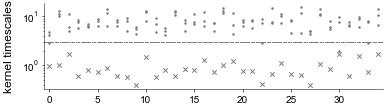

In [194]:
fig = plt.figure(figsize=(10, 3))

### kernel lengthscales ###
widths = [1]
heights = [1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=0.4, bottom=0.0, 
                        left=0.0, right=0.47)

ax = fig.add_subplot(spec[0, 0])
for n in range(len_deltas.shape[0]):
    lens = len_deltas[n]
    tlen = len_tau[n]
    ax.scatter(n*np.ones_like(lens), lens, marker='.', c='gray')
    ax.scatter(n*np.ones(1), tlen, marker='x', c='gray', s=20)
    ax.set_yscale('log')
    ax.set_ylabel('kernel timescales')
    ax.plot([-.5, len_deltas.shape[0] - 0.5], 3. * np.ones(2), '--', color='gray')
    ax.set_xlim([-.5, len_deltas.shape[0] - 0.5])

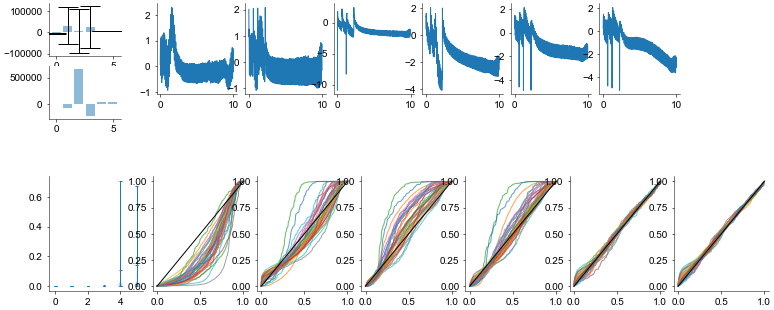

In [250]:
fig = plt.figure(figsize=(10, 4))

#fig.text(0.22, 1.05, 'repeatable trials', fontsize=12, ha='center')
#fig.text(0.78, 1.05, 'naturalistic behaviour', fontsize=12, ha='center')


### likelihoods ###
widths = [1]
heights = [1, 1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.6, 
                        left=0.0, right=0.1, wspace=0.1)

use_reg_config_names = [reg_config_names[k] for k in [0, 1, 2, 3, 5, 6]]

mdls = len(use_reg_config_names)
test_lls = np.array([regression_dict[n]['test_ells'] for n in use_reg_config_names])
train_lls = np.array([regression_dict[n]['train_ell'] for n in use_reg_config_names])

ax = fig.add_subplot(spec[0, 0])
means = test_lls.mean(-1)
sems = test_lls.std(-1) / np.sqrt(test_lls.shape[-1])
ax.bar(np.arange(mdls), means, yerr=sems, 
       align='center', alpha=0.5, ecolor='black', capsize=10)
#ax.set_ylim(7.5 * 1e4)

ax = fig.add_subplot(spec[1, 0])
means = train_lls
ax.bar(np.arange(mdls), means, 
       align='center', alpha=0.5, ecolor='black', capsize=10)
#ax.set_ylim(3.5 * 1e5)



widths = [1] * (len(use_reg_config_names) + 1)
heights = [1, 0.1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.6, 
                        left=0.15, right=1., hspace=0.3, wspace=0.1)

test_fold = 0
ne = 0
for en, n in enumerate(use_reg_config_names):
    pred_lint = regression_dict[n]['pred_log_intensities']
    pred_ts = regression_dict[n]['pred_ts']
    ax = fig.add_subplot(spec[0, en])
    ax.plot(pred_ts, pred_lint[test_fold][0, ne, :])
    #sts = regression_dict[n]['pred_spiketimes'][test_fold][ne]
    #ax = fig.add_subplot(spec[1, en])
    #for st in sts:
    #    ax.plot(st*np.ones(2), np.linspace(0, 1, 2))


### KS statistics ###
widths = [1] * (len(use_reg_config_names) + 1)
heights = [1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=0.4, bottom=0.0, 
                        left=0.0, right=1., wspace=0.1)

ax = fig.add_subplot(spec[0, 0])

mdls = len(use_reg_config_names)
p_vals = [regression_dict[n]['KS_p_value'] for n in use_reg_config_names]
#p_vals = [[0 if v is None else v for v in d] for d in p_vals]

ax.violinplot(
    p_vals, list(range(mdls)), points=20, widths=0.3,
    showmeans=True, showextrema=True, showmedians=True, 
    bw_method=1e-2, #'silverman', 
)

for en, n in enumerate(use_reg_config_names):
    quantiles = regression_dict[n]['KS_quantiles']

    ax = fig.add_subplot(spec[0, en + 1])
    for n in range(len(quantiles)):
        if quantiles[n] is not None:
            ax.plot(np.linspace(0., 1., len(quantiles[n])), quantiles[n], alpha=0.7)
    ax.plot(np.linspace(0., 1., 100), np.linspace(0., 1., 100), c='k')






plt.show()

In [83]:
def get_renewal(renewal_type, neurons, dt):
    if renewal_type == 'gamma':
        alpha = np.linspace(0.2, 100.5, neurons)
        renewal = lib.likelihoods.GammaRenewal(
            neurons,
            dt,
            alpha,
        )

    elif renewal_type == 'lognorm':
        sigma = np.linspace(0.5, 1.5, neurons)
        renewal = lib.likelihoods.LogNormalRenewal(
            neurons,
            dt,
            sigma,
        )

    elif renewal_type == 'invgauss':
        mu = np.linspace(1.0, 1.5, neurons)
        renewal = lib.likelihoods.InverseGaussianRenewal(
            neurons,
            dt,
            mu,
        )
        
    elif renewal_type == 'exponential':
        renewal = lib.likelihoods.ExponentialRenewal(
            neurons,
            dt,
        )
    
    return renewal

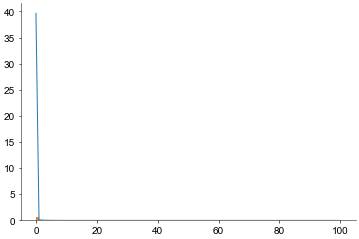

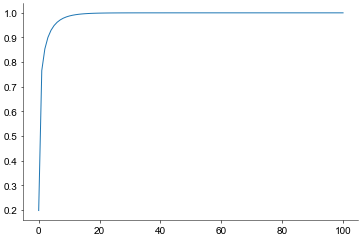

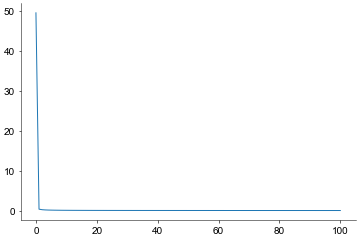

In [84]:
dt = 0.001
rm = get_renewal('gamma', 1, dt)

mc = 1000
samples = jax.vmap(rm.sample_ISI)(jr.split(prng_state, mc))


ISI = jnp.linspace(0.001, 100., 100)[:, None]

ll = jax.vmap(rm.log_density)(ISI)
plt.plot(ISI, np.exp(ll)[:, :])
plt.hist(np.array(samples)[:, -1], bins=np.array(ISI)[:, 0], density=True)
plt.show()

cd = jax.vmap(rm.cum_density)(ISI)
plt.plot(ISI, cd[:, :])
plt.show()

lh = jax.vmap(rm.log_hazard)(ISI)
plt.plot(ISI, jnp.exp(lh[:, :]))
plt.show()

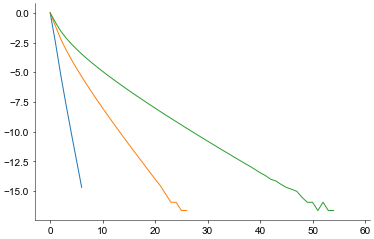

In [77]:
from tensorflow_probability.substrates import jax as tfp

igd = tfp.distributions.InverseGaussian(jnp.linspace(0.5, 1.5, 3), jnp.ones(3))

t = jnp.linspace(0.001, 100., 100)[:, None]
lh = igd.log_survival_function(t)

plt.plot((lh[:, :]))
plt.show()

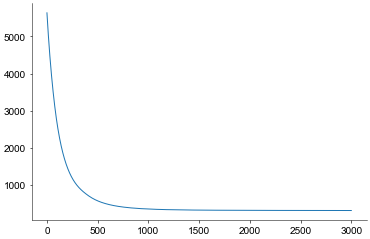

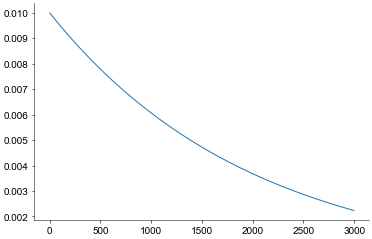

In [71]:
plt.plot(tracker['train_loss_epochs'])
plt.show()

plt.plot(tracker['learning_rates'])
plt.show()